The only purpose of this notebook is to quickly test whether the installation of TorchPhysics has been succesful. For that, the following simple ODE will be solved
$$
    \begin{cases}
        f'(t) &= f(t) &&\text{ for } t\in [0,1], \\
        f(0)  &= 1.
    \end{cases}
$$
There will be no code documentation below, as this will be part of the workshop. Please run all cells below. A plot of the true solution $f(t) = e^t$ as well as the predicition of some trained neural network should appear in the last cell if the installation of TorchPhysics was succesful.

In [1]:
import torchphysics as tp
import numpy as np
import torch
from matplotlib import pyplot as plt

import pytorch_lightning as pl

In [2]:
T = tp.spaces.R1('t')
F = tp.spaces.R1('f')

T_dom = tp.domains.Interval(T, 0, 1)

sampler_pde_condition     = tp.samplers.RandomUniformSampler(T_dom, 200)
sampler_initial_condition = tp.samplers.RandomUniformSampler(T_dom.boundary_left, 1)

def res_pde_condition(f, t):
    return f - tp.utils.grad(f, t)

def res_initial_condition(f):
    return f - 1

model = tp.models.FCN(T, F, (20,20))

pde_condition     = tp.conditions.PINNCondition(model, sampler_pde_condition, res_pde_condition)
initial_condition = tp.conditions.PINNCondition(model, sampler_initial_condition, res_initial_condition)    

In [3]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.01)

solver = tp.solver.Solver([pde_condition, initial_condition], optimizer_setting=optim)

In [4]:
trainer = pl.Trainer(max_steps=250, # number of training steps
                     logger=False,
                     benchmark=True)

trainer.fit(solver) # start training

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\s_e8mv8u\miniconda3\envs\torchphysics_workshop\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Users\s_e8mv8u\Documents\TorchPhysics Course\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 481   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
481       Trainable params
0         Non-trainable params
481       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\s_e8mv8u\miniconda3\envs\torchphysics_workshop\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\s_e8mv8u\miniconda3\envs\torchphysics_workshop\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=250` reached.


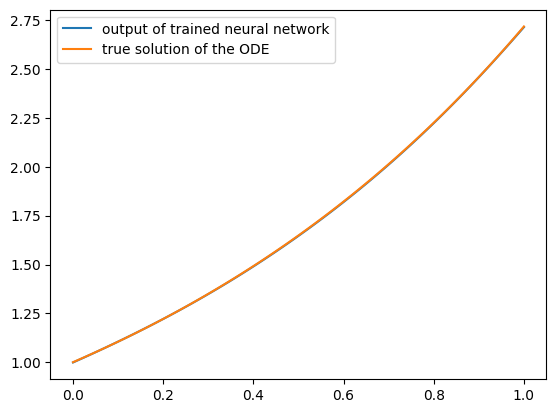

In [5]:
ts = torch.linspace(0, 1, 100)
points = tp.spaces.Points(ts.reshape(len(ts), 1), T)
output_NN = model(points).as_tensor.detach()

plt.plot(ts.numpy(), output_NN.numpy(), label='output of the trained neural network')
plt.plot(ts.numpy(), np.exp(ts),        label='true solution of the ODE')
plt.legend()
plt.show()